In [1]:
#module imports
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_probability as tfp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

In [2]:
import rpy2

## (Activate R Environment)

In [3]:
%reload_ext rpy2.ipython

C:\Users\matth\AppData\Local\r-miniconda\envs\tf\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


# Directories

In [4]:
#Set working director
os.chdir('C:/Users/matth/OneDrive/Durham/Masters/Diss')

In [5]:
# Create 'plots' directory for saving plots
plots_dir = os.path.join(os.getcwd(), "plots")
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Create 'models' directory for saving models
models_dir = os.path.join(os.getcwd(), "models")
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# R Libraries

In [6]:
%%R
library(data.table)
library(ggplot2)
library(ggnewscale)
library(tidyverse)
library(rgdal)
library(raster)
library(scoringRules)
library(scoringutils)
library(raster)

options(scipen = 6000)

-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.1.8     v dplyr   1.1.0
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.3     v forcats 0.5.2
v purrr   1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::transpose() masks data.table::transpose()


data.table 1.14.4 using 4 threads (see ?getDTthreads).  Latest news: r-datatable.com
Loading required package: sp
Please note that rgdal will be retired during 2023,
plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2022/04/12/evolution.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-6, (SVN revision 1201)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.5.2, released 2022/09/02
Path to GDAL shared files: C:/Users/matth/AppData/Local/R/win-library/4.2/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.2.1, January 1st, 2022, [PJ_VERSION: 821]
Path to PROJ shared files: C:/Users/matth/AppData/Local/R/win-library/4.2/rgdal/proj
PROJ CDN enabled: FALSE
Linking to sp version:1.6-0
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading sp or rgda

# Elevation Data and Plot

In [7]:
%%R
#Load in Elevation raster to R and convert to dataframe
elevation_r <- raster("C:/Users/matth/OneDrive/Durham/Masters/Diss/Data/DEM.tif")
elevimage <- as.data.table(raster::as.data.frame(elevation_r, xy = TRUE, na.rm = TRUE))

In [8]:
%%R
###Plot elevation raster
ggplot(elevimage) + geom_raster(aes(x = x, y = y, fill = DEM)) + theme_bw() +
  scale_fill_viridis_c(option = "cividis", begin = 0.2, end = 1, name = 'Elevation, m') + coord_equal() +
  theme(legend.justification = c(1, 1), legend.position = c(0.35, 0.99), legend.background=element_blank(),
        axis.text.y = element_text(angle = 90, vjust = 0.5, hjust=0.5)) + labs(x = "Easting (BNG)", y = "Northing (BNG)") +
  scale_x_continuous(breaks=seq(250000,500000,by=50000),limits = c(275000,475000)) + scale_y_continuous(breaks=seq(400000,700000,by=50000),limits = c(450000,675000))
ggsave(paste0("plots/NEelevation.png"), width = 68, height = 100, units = "mm", type = "cairo", dpi = 300, scale = 1.375)

In addition: Warning message:
Using ragg device as default. Ignoring `type` and `antialias` arguments 


# Gravity Anomaly Data and Plot

In [9]:
%%R
#Load in Gravity Survey data into R and convert to dataframe
gravity_r <- raster('C:/Users/matth/OneDrive/Durham/Masters/Diss/Data/Grav.tif')
gravimage<-as.data.table(raster::as.data.frame(gravity_r, xy = TRUE, na.rm = TRUE))

In [10]:
%%R
###Plot Bouguer Anomaly raster
ggplot(gravimage) + geom_raster(aes(x = x, y = y, fill = Grav)) + theme_bw() +
  scale_fill_viridis_c(option = "cividis", begin = 0.2, end = 1, name = 'Bouguer Anomaly, mGal') + coord_equal() +
  theme(legend.justification = c(1, 1), legend.position = c(0.60, 0.99), legend.background=element_blank(),
        axis.text.y = element_text(angle = 90, vjust = 0.5, hjust=0.5)) + labs(x = "Easting (BNG)", y = "Northing (BNG)") +
  scale_x_continuous(breaks=seq(250000,500000,by=50000),limits = c(275000,475000)) + scale_y_continuous(breaks=seq(400000,700000,by=50000),limits = c(440000,685000))
ggsave(paste0("plots/NEGravity.png"), width = 68, height = 100, units = "mm", type = "cairo", dpi = 300, scale = 1.375)

In addition: Warning message:
Using ragg device as default. Ignoring `type` and `antialias` arguments 


# EVI Data and Plot

In [11]:
%%R
#Load in EVI data into R and convert to dataframe
evi_r <- raster('C:/Users/matth/OneDrive/Durham/Masters/Diss/Data/VI.tif')
eviimage<-as.data.table(raster::as.data.frame(evi_r, xy = TRUE, na.rm = TRUE))

In [12]:
%%R
###Plot EVI raster
ggplot(eviimage) + geom_raster(aes(x = x, y = y, fill = Band_1/10000)) + theme_bw() +
  scale_fill_viridis_c(option = "cividis", begin = 0.2, end = 1, name = 'EVI ') + coord_equal() +
  theme(legend.justification = c(1, 1), legend.position = c(0.25, 0.99), legend.background=element_blank(),
        axis.text.y = element_text(angle = 90, vjust = 0.5, hjust=0.5)) + labs(x = "Easting (BNG)", y = "Northing (BNG)") +
  scale_x_continuous(breaks=seq(250000,500000,by=50000),limits = c(275000,475000)) + scale_y_continuous(breaks=seq(400000,700000,by=50000),limits = c(440000,685000))
ggsave(paste0("plots/NEEVI.png"), width = 68, height = 100, units = "mm", type = "cairo", dpi = 300, scale = 1.375)

In addition: Warning messages:
1: Using ragg device as default. Ignoring `type` and `antialias` arguments 
2: Raster pixels are placed at uneven horizontal intervals and will be shifted
i Consider using `geom_tile()` instead. 


# Mineral Data and Plots

In [13]:
#Read in mineral data
Chemical=pd.read_csv('C:/Users/matth/OneDrive/Durham/Masters/Diss/Data/Points.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


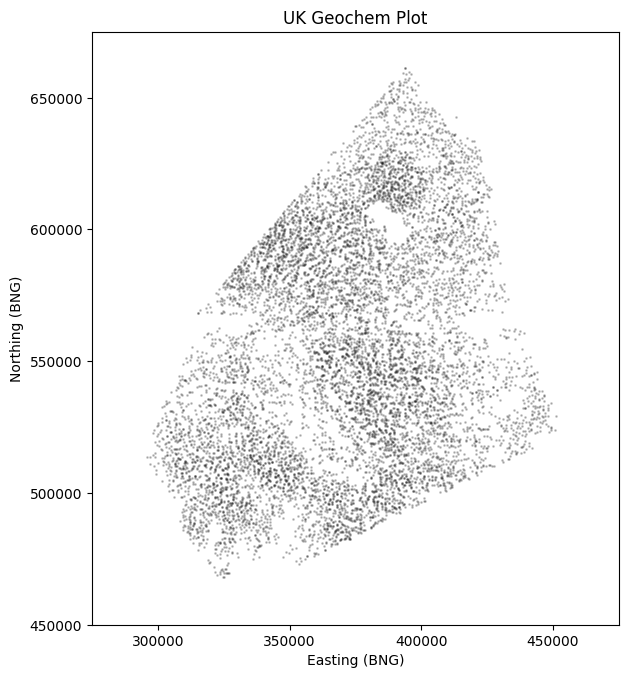

In [14]:
# Plot mineral data
plt.figure(figsize=(6.8, 10))
plt.scatter(Chemical['X_COORD'], Chemical['Y_COORD'], color='black', marker='o', s=1, alpha=0.2)
plt.xlim(275000, 475000)
plt.ylim(450000, 675000)
plt.xlabel('Easting (BNG)')
plt.ylabel('Northing (BNG)')
plt.yticks(range(450000,700000,50000))
plt.xticks(range(300000,500000,50000))
plt.title('UK Geochem Plot')
plt.legend().set_visible(False)
plt.gca().set_aspect('equal', adjustable='box')

# Save the plot
plt.savefig("plots/UKRSSPoints.png", dpi=300, bbox_inches='tight')
plt.show()


In [15]:
# Choose an element name to continue with, out of available names:
elem = "Ni_DCOES"
elemname = "Nickel"

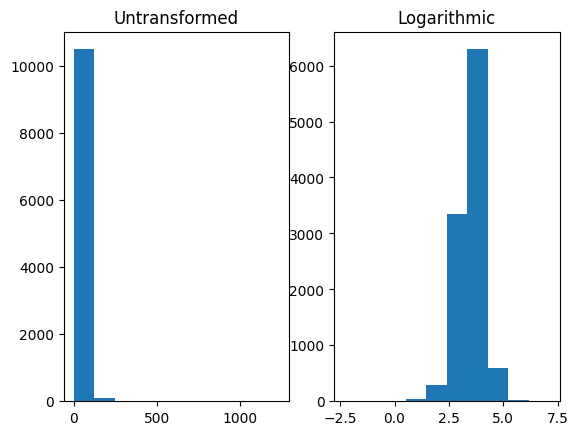

In [16]:
#Compare histograms to see whether a log transformation is appropriate to develop a Gaussian distribution. 0.1 is added to each value to remove 0 values as this would error under logarithmic transformation - this can be removed after analysis.
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(Chemical[elem])
ax2.hist(np.log(Chemical[elem]+0.1))
ax1.title.set_text('Untransformed')
ax2.title.set_text('Logarithmic')
plt.show()

In [17]:
# Should a log transformation be used?
logtrans = True

# Plot Mineral Data Coloured by Mineral Concentration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


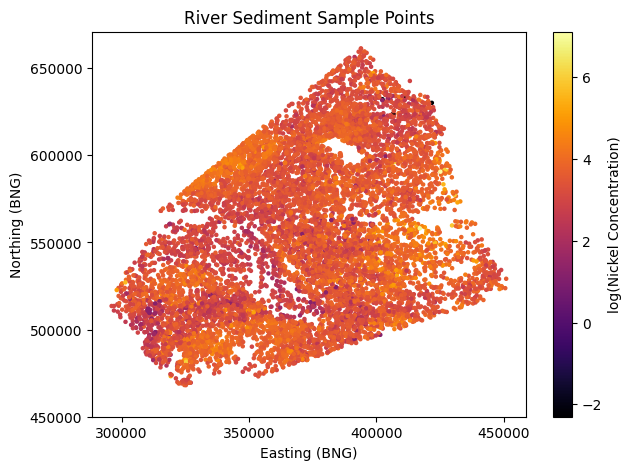

In [18]:
# Create a color scale
cmap = plt.get_cmap('inferno')
if logtrans is True:
    color_values = np.log(Chemical[elem] + 0.1)
else:
    color_values = Chemical[elem]

# Create the scatter plot
plt.figure(figsize=(7,5))
plt.scatter(Chemical['X_COORD'], Chemical['Y_COORD'], c=color_values, cmap=cmap, s=5)
if logtrans:
    norm = plt.Normalize(np.log(Chemical[elem] + 0.1).min(), np.log(Chemical[elem] + 0.1).max())
else:
    norm = plt.Normalize(Chemical[elem].min(), Chemical[elem].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label(f"log({elemname} Concentration)" if logtrans else f"{elemname} Concentration")
plt.xlabel('Easting (BNG)')
plt.ylabel('Northing (BNG)')
plt.yticks(range(450000,700000,50000))
plt.xticks(range(300000,500000,50000))
plt.title('River Sediment Sample Points')
plt.legend().set_visible(False)  # Legend not shown in this case

# Show the plot and save it
plt.savefig(f'plots/{elemname}_Points.png')

# Extract Location Data, Elevation, Bouguer Anomaly and EVI Values at Each Sample Point

In [19]:
%%R -i Chemical

#Load Mineral data into R, to allow for bilinear sample extraction from rasters
Chemical <- as.data.table(Chemical)

In [20]:
%%R -i elem -o Chemical

#Extract Elevation, Bouguer Anomaly and EVI at each sample point, and remove NA's
Chemical[, elevation := raster::extract(elevation_r, Chemical[, c("X_COORD", "Y_COORD"), with = FALSE], method = "bilinear"), ]
Chemical[, gravity := raster::extract(gravity_r, Chemical[, c("X_COORD", "Y_COORD"), with = FALSE], method = "bilinear"), ]
Chemical[, evi := raster::extract(evi_r, Chemical[, c("X_COORD", "Y_COORD"), with = FALSE], method = "bilinear"), ]

Chemical <- Chemical[!is.na(Chemical[,get(elem)]) & !is.na(Chemical$elevation) & !is.na(Chemical$gravity) & !is.na(Chemical$evi)]

# Image classification

In [21]:
#Set the pixel size and image size of the images for use in the convolutional networks
imagedim = 32
imageres = 250

In [22]:
%%R -i imagedim,imageres,Chemical

### Extract sample-centred images, for use in feature learning ####
#Create array of empty images
imgs_elev <- array(dim = c(nrow(Chemical), imagedim, imagedim))
imgs_grav <- array(dim = c(nrow(Chemical), imagedim, imagedim))
imgs_evi <- array(dim = c(nrow(Chemical), imagedim, imagedim))

#Creat image reference for use in loop
cells <- as.data.table(expand.grid(x = seq.int(from = imageres/2, by = imageres, length.out = imagedim)-(imageres*imagedim)/2, 
                                   y = seq.int(from = imageres/2, by = imageres, length.out = imagedim)-(imageres*imagedim)/2))
cells[ ,coordx := rep(1:imagedim, imagedim),]
cells[ ,coordy := rep(1:imagedim, each = imagedim),]

#Loop through each pixel and extract values, for each sample point
for(xmeter in unique(cells$coordx)){
  for(ymeter in unique(cells$coordy)){
    imgs_elev[,xmeter,ymeter] <- extract(elevation_r, method = "bilinear",
                                    cbind(Chemical$X_COORD + cells[coordx == xmeter & coordy == ymeter]$x, Chemical$Y_COORD + cells[coordx == xmeter & coordy == ymeter]$y)) 
    imgs_grav[,xmeter,ymeter] <- extract(gravity_r, method = "bilinear",
                                    cbind(Chemical$X_COORD + cells[coordx == xmeter & coordy == ymeter]$x, Chemical$Y_COORD + cells[coordx == xmeter & coordy == ymeter]$y))
    imgs_evi[,xmeter,ymeter] <- extract(evi_r, method = "bilinear",
                                    cbind(Chemical$X_COORD + cells[coordx == xmeter & coordy == ymeter]$x, Chemical$Y_COORD + cells[coordx == xmeter & coordy == ymeter]$y))
  }
}

#Set NA values to 0
imgs_elev[is.na(imgs_elev)] = 0
imgs_grav[is.na(imgs_grav)] = 0
imgs_evi[is.na(imgs_evi)] = 0

In [23]:
%%R -o elev_ann,grav_ann,evi_ann

#Sample centre the values of each image
elev_ann = imgs_elev - Chemical$elevation
grav_ann = imgs_grav - Chemical$gravity
evi_ann = imgs_evi - Chemical$evi

# Location data

In [24]:
# Extract easting, northing, elevation, bouguer anomaly and evi as location variables
loc = Chemical.loc[:,["X_COORD", "Y_COORD", "elevation","gravity",'evi']]

# Creating Test Train Val Splits

In [25]:
#Create train, validation and test splits
train, testval = train_test_split(np.arange(Chemical.shape[0]), train_size=0.7, random_state = 2023)
val, test = train_test_split(testval, train_size=0.5, random_state = 2001)

In [26]:
#Split each of the inputs into train, validation and test
loc_train = loc.iloc[train]
loc_val = loc.iloc[val]
loc_test = loc.iloc[test]

In [27]:
elev_ann_train = elev_ann[train,]
elev_ann_val = elev_ann[val,]
elev_ann_test = elev_ann[test,]

In [28]:
grav_ann_train = grav_ann[train,]
grav_ann_val = grav_ann[val,]
grav_ann_test = grav_ann[test,]

In [29]:
evi_ann_train = evi_ann[train,]
evi_ann_val = evi_ann[val,]
evi_ann_test = evi_ann[test,]

# Normalising

In [30]:
#Normalise each input by the TRAIN standard deviation, to prevent data leakage
elev_sd = elev_ann_train.std()

elev_ann_train = elev_ann_train/elev_sd
elev_ann_val = elev_ann_val/elev_sd
elev_ann_test = elev_ann_test/elev_sd

In [31]:
grav_sd = grav_ann_train.std()

grav_ann_train = grav_ann_train/grav_sd
grav_ann_val = grav_ann_val/grav_sd
grav_ann_test = grav_ann_test/grav_sd

In [32]:
evi_sd = evi_ann_train.std()

evi_ann_train = evi_ann_train/evi_sd
evi_ann_val = evi_ann_val/evi_sd
evi_ann_test = evi_ann_test/evi_sd

In [33]:
locmean = loc_train.mean(axis=0)
locsd = loc_train.std(axis=0)

loc_train = (loc_train-locmean)/locsd
loc_val = (loc_val-locmean)/locsd
loc_test = (loc_test-locmean)/locsd

# Inputs and Outputs

In [34]:
# Finally combine the independent variables/inputs
x_train = [elev_ann_train,grav_ann_train,evi_ann_train,loc_train]
x_val = [elev_ann_val,grav_ann_val,evi_ann_val,loc_val]
x_test = [elev_ann_test,grav_ann_test,evi_ann_test,loc_test]

In [35]:
# Create the dependant variables/expected outputs
if(logtrans == True):
    y_train = np.log(Chemical.loc[:, elem]+0.1)[train]
    y_val = np.log(Chemical.loc[:, elem]+0.1)[val]
    y_test = np.log(Chemical.loc[:, elem]+0.1)[test]
else:
    y_train = Chemical.loc[:, elem][train]
    y_val = Chemical.loc[:, elem][val]
    y_test = Chemical.loc[:, elem][test]

# Construct the deep learning neural network

In [36]:
#Set tuned dropout rate for convolutional and fully connected layers
dropratespat=0.65
dropratedense=0.3

In [37]:
# Convolutional stack for elevation images:
conv_input_elev = layers.Input(shape=(imagedim, imagedim, 1), name='conv_input_elev')

conv_output_elev = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=3)(conv_input_elev)
conv_output_elev = layers.Activation('relu')(conv_output_elev)
conv_output_elev = layers.SpatialDropout2D(rate=dropratespat)(conv_output_elev)

conv_output_elev = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_elev)
conv_output_elev = layers.Activation('relu')(conv_output_elev)
conv_output_elev = layers.SpatialDropout2D(rate=dropratespat)(conv_output_elev)

conv_output_elev = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_elev)
conv_output_elev = layers.Activation('relu')(conv_output_elev)
conv_output_elev = layers.SpatialDropout2D(rate=dropratespat)(conv_output_elev)

conv_output_elev = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_elev)
conv_output_elev = layers.Activation('relu')(conv_output_elev)
conv_output_elev = layers.SpatialDropout2D(rate=dropratespat)(conv_output_elev)

conv_output_elev = layers.GlobalAveragePooling2D()(conv_output_elev)
conv_output_elev = layers.Flatten()(conv_output_elev)

In [38]:
# Convolutional stack for bouguer anomaly images:
conv_input_grav = layers.Input(shape=(imagedim, imagedim, 1), name='conv_input_grav')

conv_output_grav = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=3)(conv_input_grav)
conv_output_grav = layers.Activation('relu')(conv_output_grav)
conv_output_grav = layers.SpatialDropout2D(rate=dropratespat)(conv_output_grav)

conv_output_grav = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_grav)
conv_output_grav = layers.Activation('relu')(conv_output_grav)
conv_output_grav = layers.SpatialDropout2D(rate=dropratespat)(conv_output_grav)

conv_output_grav = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_grav)
conv_output_grav = layers.Activation('relu')(conv_output_grav)
conv_output_grav = layers.SpatialDropout2D(rate=dropratespat)(conv_output_grav)

conv_output_grav = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_grav)
conv_output_grav = layers.Activation('relu')(conv_output_grav)
conv_output_grav = layers.SpatialDropout2D(rate=dropratespat)(conv_output_grav)

conv_output_grav = layers.GlobalAveragePooling2D()(conv_output_grav)
conv_output_grav = layers.Flatten()(conv_output_grav)

In [39]:
# Convolutional stack for EVI images:
conv_input_evi = layers.Input(shape=(imagedim, imagedim, 1), name='conv_input_evi')

conv_output_evi = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=3)(conv_input_evi)
conv_output_evi = layers.Activation('relu')(conv_output_evi)
conv_output_evi = layers.SpatialDropout2D(rate=dropratespat)(conv_output_evi)

conv_output_evi = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_evi)
conv_output_evi = layers.Activation('relu')(conv_output_evi)
conv_output_evi = layers.SpatialDropout2D(rate=dropratespat)(conv_output_evi)

conv_output_evi = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_evi)
conv_output_evi = layers.Activation('relu')(conv_output_evi)
conv_output_evi = layers.SpatialDropout2D(rate=dropratespat)(conv_output_evi)

conv_output_evi = layers.Conv2D(128, kernel_size=(3, 3), dilation_rate=1, strides=1)(conv_output_evi)
conv_output_evi = layers.Activation('relu')(conv_output_evi)
conv_output_evi = layers.SpatialDropout2D(rate=dropratespat)(conv_output_evi)

conv_output_evi = layers.GlobalAveragePooling2D()(conv_output_evi)
conv_output_evi = layers.Flatten()(conv_output_evi)

In [40]:
# Auxiliary input for locational and auxiliary data:
auxiliary_input = layers.Input(shape=(5,), name='aux_input')

auxiliary_output = layers.Dense(1920)(auxiliary_input)
auxiliary_output = layers.Activation('relu')(auxiliary_output)
auxiliary_output = layers.Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = layers.Flatten()(auxiliary_output)

In [41]:
# Concated inputs and final output:
concatenated_output = layers.concatenate([conv_output_elev,conv_output_grav,conv_output_evi,auxiliary_output])
main_output = layers.Dense(1024)(concatenated_output)
main_output = layers.Activation('relu')(main_output)
main_output = layers.Dropout(rate=dropratedense)(main_output)
main_output = layers.Dense(256)(main_output)
main_output = layers.Activation('relu')(main_output)
main_output = layers.Dropout(rate=dropratedense)(main_output)
main_output = layers.Dense(units=2, activation='linear', name='dist_param')(main_output)
main_output = tfp.layers.DistributionLambda(lambda x: tfp.distributions.Normal(
    loc=x[..., :1],
    #Softplus link function to force the variance to be positive
    scale=1e-3 + tf.math.softplus(0.1 * x[..., 1:])
))(main_output)

In [42]:
#Combining the final model
np.random.seed(1)
tf.random.set_seed(1)
model = Model(inputs=[conv_input_elev, conv_input_grav, conv_input_evi, auxiliary_input], outputs=main_output)

In [43]:
#Summary of the mode
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv_input_elev (InputLayer)   [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv_input_grav (InputLayer)   [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv_input_evi (InputLayer)    [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 10, 10, 128)  1280        ['conv_input_elev[0][0]']        
                                                                                              

                                                                                                  
 activation_11 (Activation)     (None, 4, 4, 128)    0           ['conv2d_11[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 1920)         11520       ['aux_input[0][0]']              
                                                                                                  
 spatial_dropout2d_3 (SpatialDr  (None, 4, 4, 128)   0           ['activation_3[0][0]']           
 opout2D)                                                                                         
                                                                                                  
 spatial_dropout2d_7 (SpatialDr  (None, 4, 4, 128)   0           ['activation_7[0][0]']           
 opout2D)                                                                                         
          

In [44]:
#Define Negative Log Likelihood loss function and set the optimiser
def negloglik(y, model):
    return -model.log_prob(y)
opt = tf.keras.optimizers.Adam(learning_rate=0.002, decay=1e-6)

In [45]:
#Compile the model
model.compile(loss=negloglik, optimizer=opt)

# Train the Model

In [46]:
# Set the Batch Size and Number of Epochs
batch_size = 2**12
epochs = 600


In [47]:
#Fit the model
history = model.fit(x=x_train, y=y_train, batch_size=batch_size,epochs=epochs,validation_data=(x_val, y_val),shuffle=True,verbose=2,callbacks=[EarlyStopping(monitor="val_loss", patience=200),ModelCheckpoint(filepath="models/modelweights.hdf5",monitor="val_loss",save_best_only=True,save_weights_only=True)])
min_val_loss = min(history.history['val_loss'])

Epoch 1/600
2/2 - 12s - loss: 8.7702 - val_loss: 11.7542 - 12s/epoch - 6s/step
Epoch 2/600
2/2 - 10s - loss: 13.4139 - val_loss: 4.1682 - 10s/epoch - 5s/step
Epoch 3/600
2/2 - 13s - loss: 4.0389 - val_loss: 4.4090 - 13s/epoch - 6s/step
Epoch 4/600
2/2 - 13s - loss: 3.7225 - val_loss: 2.2316 - 13s/epoch - 6s/step
Epoch 5/600
2/2 - 12s - loss: 1.9856 - val_loss: 1.5705 - 12s/epoch - 6s/step
Epoch 6/600
2/2 - 13s - loss: 1.8071 - val_loss: 2.1441 - 13s/epoch - 6s/step
Epoch 7/600
2/2 - 13s - loss: 2.3570 - val_loss: 2.2100 - 13s/epoch - 7s/step
Epoch 8/600
2/2 - 13s - loss: 2.2768 - val_loss: 1.7899 - 13s/epoch - 6s/step
Epoch 9/600
2/2 - 12s - loss: 1.8323 - val_loss: 1.5383 - 12s/epoch - 6s/step
Epoch 10/600
2/2 - 13s - loss: 1.6188 - val_loss: 1.6321 - 13s/epoch - 7s/step
Epoch 11/600
2/2 - 13s - loss: 1.7071 - val_loss: 1.7971 - 13s/epoch - 6s/step
Epoch 12/600
2/2 - 13s - loss: 1.8162 - val_loss: 1.8045 - 13s/epoch - 7s/step
Epoch 13/600
2/2 - 13s - loss: 1.7978 - val_loss: 1.6782 - 

Epoch 105/600
2/2 - 14s - loss: 1.0027 - val_loss: 0.8880 - 14s/epoch - 7s/step
Epoch 106/600
2/2 - 14s - loss: 1.0006 - val_loss: 0.8880 - 14s/epoch - 7s/step
Epoch 107/600
2/2 - 14s - loss: 0.9986 - val_loss: 0.8840 - 14s/epoch - 7s/step
Epoch 108/600
2/2 - 14s - loss: 0.9943 - val_loss: 0.8817 - 14s/epoch - 7s/step
Epoch 109/600
2/2 - 14s - loss: 0.9975 - val_loss: 0.8814 - 14s/epoch - 7s/step
Epoch 110/600
2/2 - 14s - loss: 0.9837 - val_loss: 0.8717 - 14s/epoch - 7s/step
Epoch 111/600
2/2 - 13s - loss: 0.9924 - val_loss: 0.8838 - 13s/epoch - 7s/step
Epoch 112/600
2/2 - 14s - loss: 0.9771 - val_loss: 0.8690 - 14s/epoch - 7s/step
Epoch 113/600
2/2 - 13s - loss: 0.9847 - val_loss: 0.8683 - 13s/epoch - 7s/step
Epoch 114/600
2/2 - 13s - loss: 0.9669 - val_loss: 0.8646 - 13s/epoch - 6s/step
Epoch 115/600
2/2 - 13s - loss: 0.9748 - val_loss: 0.8574 - 13s/epoch - 6s/step
Epoch 116/600
2/2 - 12s - loss: 0.9783 - val_loss: 0.8539 - 12s/epoch - 6s/step
Epoch 117/600
2/2 - 13s - loss: 0.9689 -

Epoch 208/600
2/2 - 13s - loss: 0.8844 - val_loss: 0.7780 - 13s/epoch - 6s/step
Epoch 209/600
2/2 - 13s - loss: 0.8980 - val_loss: 0.7568 - 13s/epoch - 6s/step
Epoch 210/600
2/2 - 13s - loss: 0.8800 - val_loss: 0.7643 - 13s/epoch - 6s/step
Epoch 211/600
2/2 - 12s - loss: 0.8883 - val_loss: 0.7701 - 12s/epoch - 6s/step
Epoch 212/600
2/2 - 14s - loss: 0.8831 - val_loss: 0.7522 - 14s/epoch - 7s/step
Epoch 213/600
2/2 - 13s - loss: 0.8899 - val_loss: 0.7610 - 13s/epoch - 6s/step
Epoch 214/600
2/2 - 14s - loss: 0.8822 - val_loss: 0.7522 - 14s/epoch - 7s/step
Epoch 215/600
2/2 - 13s - loss: 0.8741 - val_loss: 0.7533 - 13s/epoch - 7s/step
Epoch 216/600
2/2 - 14s - loss: 0.8795 - val_loss: 0.7501 - 14s/epoch - 7s/step
Epoch 217/600
2/2 - 13s - loss: 0.8868 - val_loss: 0.7467 - 13s/epoch - 6s/step
Epoch 218/600
2/2 - 14s - loss: 0.8790 - val_loss: 0.7786 - 14s/epoch - 7s/step
Epoch 219/600
2/2 - 15s - loss: 0.8837 - val_loss: 0.7437 - 15s/epoch - 7s/step
Epoch 220/600
2/2 - 14s - loss: 0.8802 -

Epoch 311/600
2/2 - 14s - loss: 0.8350 - val_loss: 0.7207 - 14s/epoch - 7s/step
Epoch 312/600
2/2 - 13s - loss: 0.8256 - val_loss: 0.7045 - 13s/epoch - 7s/step
Epoch 313/600
2/2 - 13s - loss: 0.8346 - val_loss: 0.7209 - 13s/epoch - 7s/step
Epoch 314/600
2/2 - 14s - loss: 0.8381 - val_loss: 0.7325 - 14s/epoch - 7s/step
Epoch 315/600
2/2 - 13s - loss: 0.8399 - val_loss: 0.6988 - 13s/epoch - 7s/step
Epoch 316/600
2/2 - 12s - loss: 0.8367 - val_loss: 0.7244 - 12s/epoch - 6s/step
Epoch 317/600
2/2 - 13s - loss: 0.8359 - val_loss: 0.7030 - 13s/epoch - 6s/step
Epoch 318/600
2/2 - 12s - loss: 0.8326 - val_loss: 0.7031 - 12s/epoch - 6s/step
Epoch 319/600
2/2 - 13s - loss: 0.8262 - val_loss: 0.7163 - 13s/epoch - 6s/step
Epoch 320/600
2/2 - 13s - loss: 0.8325 - val_loss: 0.7009 - 13s/epoch - 6s/step
Epoch 321/600
2/2 - 13s - loss: 0.8347 - val_loss: 0.7136 - 13s/epoch - 7s/step
Epoch 322/600
2/2 - 14s - loss: 0.8524 - val_loss: 0.7302 - 14s/epoch - 7s/step
Epoch 323/600
2/2 - 13s - loss: 0.8415 -

Epoch 414/600
2/2 - 12s - loss: 0.7875 - val_loss: 0.7051 - 12s/epoch - 6s/step
Epoch 415/600
2/2 - 13s - loss: 0.7889 - val_loss: 0.6711 - 13s/epoch - 6s/step
Epoch 416/600
2/2 - 13s - loss: 0.7864 - val_loss: 0.7131 - 13s/epoch - 6s/step
Epoch 417/600
2/2 - 13s - loss: 0.8010 - val_loss: 0.6732 - 13s/epoch - 6s/step
Epoch 418/600
2/2 - 13s - loss: 0.7841 - val_loss: 0.6672 - 13s/epoch - 6s/step
Epoch 419/600
2/2 - 14s - loss: 0.8062 - val_loss: 0.7585 - 14s/epoch - 7s/step
Epoch 420/600
2/2 - 14s - loss: 0.8178 - val_loss: 0.6669 - 14s/epoch - 7s/step
Epoch 421/600
2/2 - 14s - loss: 0.7829 - val_loss: 0.6856 - 14s/epoch - 7s/step
Epoch 422/600
2/2 - 14s - loss: 0.7899 - val_loss: 0.6830 - 14s/epoch - 7s/step
Epoch 423/600
2/2 - 14s - loss: 0.7803 - val_loss: 0.6719 - 14s/epoch - 7s/step
Epoch 424/600
2/2 - 14s - loss: 0.8021 - val_loss: 0.6782 - 14s/epoch - 7s/step
Epoch 425/600
2/2 - 14s - loss: 0.7904 - val_loss: 0.6844 - 14s/epoch - 7s/step
Epoch 426/600
2/2 - 14s - loss: 0.7791 -

Epoch 517/600
2/2 - 14s - loss: 0.7481 - val_loss: 0.6481 - 14s/epoch - 7s/step
Epoch 518/600
2/2 - 13s - loss: 0.7534 - val_loss: 0.6653 - 13s/epoch - 7s/step
Epoch 519/600
2/2 - 13s - loss: 0.7424 - val_loss: 0.6573 - 13s/epoch - 6s/step
Epoch 520/600
2/2 - 14s - loss: 0.7445 - val_loss: 0.6534 - 14s/epoch - 7s/step
Epoch 521/600
2/2 - 13s - loss: 0.7434 - val_loss: 0.6610 - 13s/epoch - 7s/step
Epoch 522/600
2/2 - 13s - loss: 0.7403 - val_loss: 0.6618 - 13s/epoch - 7s/step
Epoch 523/600
2/2 - 14s - loss: 0.7504 - val_loss: 0.6535 - 14s/epoch - 7s/step
Epoch 524/600
2/2 - 13s - loss: 0.7628 - val_loss: 0.6533 - 13s/epoch - 6s/step
Epoch 525/600
2/2 - 14s - loss: 0.7503 - val_loss: 0.6619 - 14s/epoch - 7s/step
Epoch 526/600
2/2 - 15s - loss: 0.7508 - val_loss: 0.6682 - 15s/epoch - 7s/step
Epoch 527/600
2/2 - 15s - loss: 0.7462 - val_loss: 0.6516 - 15s/epoch - 7s/step
Epoch 528/600
2/2 - 14s - loss: 0.7438 - val_loss: 0.6657 - 14s/epoch - 7s/step
Epoch 529/600
2/2 - 15s - loss: 0.7584 -

In [48]:
#Show minimum validation loss, which will be the model used
print("Minimum Validation Loss:", {min_val_loss})

Minimum Validation Loss: {0.6374699473381042}


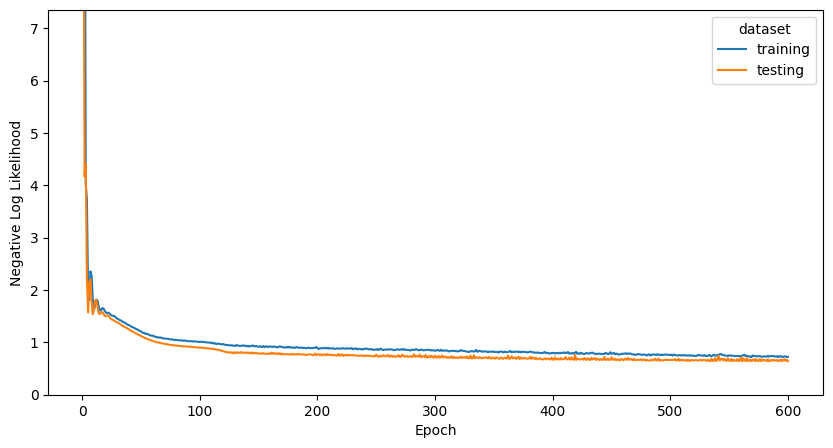

In [49]:
# Show training history
trainhist = pd.DataFrame({'training': history.history['loss'], 'testing': history.history['val_loss']})
trainhist['epoch'] = np.arange(1, 601)
plt.figure(figsize=(10, 5))
sns.lineplot(data=pd.melt(trainhist, id_vars='epoch', value_name='NLL', var_name='dataset'), x='epoch', y='NLL', hue='dataset')
plt.ylim(0, np.quantile(trainhist['testing'], 0.999))
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.savefig(f"plots/Training_{elemname}.png", dpi=800)
plt.show()

# Save as Mean Model

In [50]:
#Load Model Weights from Lowest Validation Loss Model
model.load_weights("models/modelweights.hdf5")

In [51]:
# Compile same model to save entire model with weights
meanmodel = Model(inputs=[model.input],outputs=[model.get_layer("dist_param").output])

meanmodel.save("models/meanmodel")
meanmodel = load_model("models/meanmodel")

tf.keras.backend.set_learning_phase(0)

INFO:tensorflow:Assets written to: models/meanmodel\assets


INFO:tensorflow:Assets written to: models/meanmodel\assets


C:\Users\matth\AppData\Local\r-miniconda\envs\tf\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


# Evaluate the Model

50/50 [==============================] - 1s 14ms/step


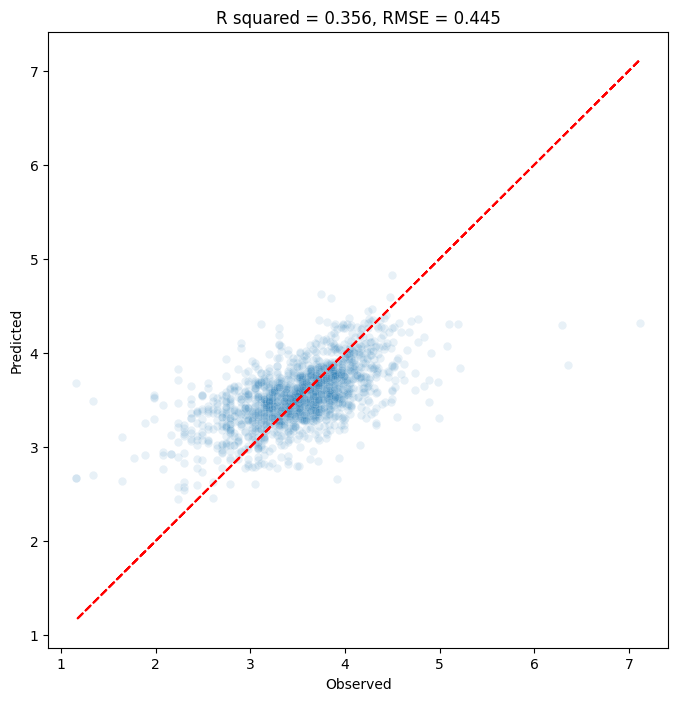

In [52]:
# Create dataframe of observed and predicted test values using model
holdout = pd.DataFrame({'obs': y_test.ravel(), 'preds': meanmodel.predict(x_test)[:,0].ravel()})

#Calculate R Squared and RMSE
r_squared = np.round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1] ** 2, 3)
rmse = np.round(np.sqrt(np.mean((holdout['preds'] - holdout['obs']) ** 2)), 3)

# Plot observed vs predicted
plt.figure(figsize=(8, 8))
plt.scatter
sns.scatterplot(data=holdout, x='obs', y='preds', alpha=0.1)
plt.plot(holdout['obs'], holdout['obs'], color='red', linestyle='--')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title(f"R squared = {r_squared}, RMSE = {rmse}")
plt.savefig(f"plots/mean_holdout_{elemname}.png", dpi=800)
plt.show()

In [53]:
# Print R Squared and RMSE
print(f"R squared = {r_squared}")
print(f"RMSE = {rmse}")

R squared = 0.356
RMSE = 0.445


In [54]:
# Create list of predictions
tf.keras.backend.set_learning_phase(1)
y_pred = meanmodel.predict(x_test, batch_size=batch_size)[:,0]

C:\Users\matth\AppData\Local\r-miniconda\envs\tf\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


1/1 [==============================] - 1s 638ms/step


In [55]:
%%R -i y_test,y_pred -o mean_testcrps
#Calculate CRPS score
testcrps <- crps_sample(y_test, drop(replicate(50,y_pred)))
mean_testcrps <- mean(testcrps)

In [56]:
#Show CRPS score
print("Mean CRPS:", mean_testcrps)

Mean CRPS: [0.32702395]


In [57]:
%%R -i y_test,y_pred,logtrans,elem,elemname
#Plot Probability Density
ggplot() +
  stat_density(data = data.frame(x = as.numeric(y_test), data = "Observed"), aes(x = x, col = data, linetype = data), geom = "line") +
  stat_density(data = data.frame(x = as.numeric(replicate(50, y_pred)), data = "Predicted"), 
               aes(x = x, col = data, linetype = data), geom = "line") +
  scale_x_continuous(limits = c(0,10)) + theme_bw() + theme(legend.justification = c(1,1), legend.position = c(0.95, 0.95), legend.title = element_blank()) +
  labs(x = if(logtrans == TRUE){paste0("log(", elem, ")")}else{paste(elem)},
       y = 'Density',
       subtitle = paste0("CRPS = ", round(mean(testcrps), 2)),
       tag = expression(bold("b")))
ggsave(paste0("plots/distribution_",elemname,".png"), width = 89, height = 89, units = "mm", type = "cairo", dpi = 300, scale = 1.375)

In addition: Warning message:
Using ragg device as default. Ignoring `type` and `antialias` arguments 


In [58]:
%%R -i y_pred
#Test Quantiles
covtest <- melt(as.data.table(data.frame(y = y_test, x = drop(replicate(100, y_pred)))), id.vars = "y")
paste("95% =", round(nrow(covtest[y < quantile(value, 0.975) & y > quantile(value, 0.025)])/nrow(covtest), 3))

[1] "95% = 0.824"


In [59]:
%%R
paste("70% =", round(nrow(covtest[y < quantile(value, 0.85) & y > quantile(value, 0.15)])/nrow(covtest), 3))

[1] "70% = 0.447"


In [60]:
%%R
paste("50% =", round(nrow(covtest[y < quantile(value, 0.75) & y > quantile(value, 0.25)])/nrow(covtest), 3))

[1] "50% = 0.295"


# Mean Map

In [61]:
%%R -o predgrid
###Create Inputs for National Scale maps
#Start with auxiliary info
gbelevcoarse <- aggregate(elevation_r, fact=1)
predgrid <- as.data.table(raster::as.data.frame(gbelevcoarse, xy = TRUE, na.rm = TRUE))[x > 0 & y > 0]
setnames(predgrid, "DEM", "elevation")
predgrid$gravity <- extract(gravity_r,method='bilinear', cbind(predgrid$x,predgrid$y))
predgrid$evi <- extract(evi_r,method='bilinear', cbind(predgrid$x,predgrid$y))

In addition: Warning message:
In .local(x, ...) : all fact(s) were 1, nothing to aggregate


In [62]:
%%R -o predimgs_elevann,predimgs_gravann,predimgs_eviann
#Next get grid cell-centred images for the convolutional stack
predimgs_elev <- array(dim = c(nrow(predgrid), imagedim, imagedim))
predimgs_grav <- array(dim = c(nrow(predgrid), imagedim, imagedim))
predimgs_evi <- array(dim = c(nrow(predgrid), imagedim, imagedim))

for(xmeter in unique(cells$coordx)){
  for(ymeter in unique(cells$coordy)){
    predimgs_elev[,xmeter,ymeter] <- extract(elevation_r, method = "bilinear",
                                        cbind(predgrid$x + cells[coordx == xmeter & coordy == ymeter]$x, predgrid$y + cells[coordx == xmeter & coordy == ymeter]$y))
    predimgs_grav[,xmeter,ymeter] <- extract(gravity_r, method = "bilinear",
                                        cbind(predgrid$x + cells[coordx == xmeter & coordy == ymeter]$x, predgrid$y + cells[coordx == xmeter & coordy == ymeter]$y)) 
    predimgs_evi[,xmeter,ymeter] <- extract(evi_r, method = "bilinear",
                                        cbind(predgrid$x + cells[coordx == xmeter & coordy == ymeter]$x, predgrid$y + cells[coordx == xmeter & coordy == ymeter]$y)) 
  }
}

predimgs_elev[is.na(predimgs_elev)] = 0
predimgs_elevann <- predimgs_elev - predgrid$elevation

predimgs_grav[is.na(predimgs_grav)] = 0
predimgs_gravann <- predimgs_grav - predgrid$gravity

predimgs_evi[is.na(predimgs_evi)] = 0
predimgs_eviann <- predimgs_evi - predgrid$evi


In [63]:
#Normalise the image arrays
predimgs_elevann = predimgs_elevann/elev_sd
predimgs_gravann = predimgs_gravann/grav_sd
predimgs_eviann = predimgs_eviann/evi_sd

In [64]:
#Normalise the auxiliary data
predloc = predgrid[['x', 'y', 'elevation','gravity','evi']]
predloc=predloc.rename(columns={'x':'X_COORD','y':'Y_COORD'})

predloc_ann = (predloc-locmean)/locsd

In [65]:
#Generate predictions for full study area for both mean and variance (aleatoric uncertainty)
pred = meanmodel.predict([predimgs_elevann,predimgs_gravann,predimgs_eviann,predloc_ann], batch_size=batch_size)
predgrid[elemname] = pred[:,0]
aleatoric = np.array(1e-3 + tf.math.softplus(0.1 * pred[:,1]))

#Generate mean raster
predraster = predgrid[['x','y',elemname]]

17/17 [==============================] - 25s 1s/step


In [66]:
%%R -i predraster,elemname,holdout

#Plot the mean map
ggplot(predraster) + geom_raster(aes(x = x, y = y, fill = get(elemname)), interpolate = FALSE) + theme_bw() + coord_equal() +
  scale_fill_viridis_c(option = "B", name = if(logtrans == TRUE){paste0("Predicted\nlog(",elemname," Concentration)")}else{paste("predicted\n", elemname, " Concentration")}) + labs(x = "Easting (metres BNG)", y = "Northing (metres BNG)") +
  theme(legend.justification = c(1, 1), legend.position = c(0.35, 0.99), legend.background=element_blank(),
        axis.text.y = element_text(angle = 90, vjust = 0.5, hjust=0.5)) +
  scale_y_continuous(breaks = seq(450000,700000, length.out = 6), labels = paste(seq(450000,700000, length.out = 6)), expand = c(0,0), limits = c(450000, 700000)) +
  scale_x_continuous(expand = c(0,0), limits = c(250000, 500000))
ggsave(paste0("plots/", elemname, "_predmap.png"), width = 128, height = 225, units = "mm", type = "cairo", dpi = 300, scale = 1.375)


In addition: Warning message:
Using ragg device as default. Ignoring `type` and `antialias` arguments 


# Aleatoric and Epistemic Uncertainty Maps

In [67]:
#Remove variables to free up memory space
import gc
del elev_ann, elev_ann_test, elev_ann_train, elev_ann_val, elev_sd, evi_ann, evi_ann_test, evi_ann_train, evi_ann_val, evi_sd, grav_ann, grav_ann_test, grav_ann_train, grav_ann_val, grav_sd, loc, loc_test, loc_train, loc_val, locmean, locsd, x_test, x_train, x_val, y_test, y_train, y_val, y_pred, predraster, predloc
gc.collect()

4165

In [68]:
#Create Uncertainty Grid (have to aggregate to double cell size due to memory error)
predgrid_uncer = predgrid

In [69]:
#Create list for repeated predictions
predictions_list = []

#Set Seed
tf.random.set_seed(2)

#Repeat predictions for full study area, and append to a list
for _ in range(100):
    predictions = model.predict([predimgs_elevann,predimgs_gravann,predimgs_eviann,predloc_ann], batch_size=batch_size)
    predictions_list.append(predictions)

# Convert to numpy array
predictions_array = np.array(predictions_list)

# Calculate the standard deviation for each data point, which we can attribute to epistemic uncertainty
epistemic = np.std(predictions_array, axis=0)

17/17 [==============================] - 39s 2s/step


In [70]:
#Add epistemic and aleatoric uncertainties to grid
predgrid_uncer['Epistemic'] = epistemic
predgrid_uncer['Aleatoric']= aleatoric

predgrid_uncer = predgrid_uncer[['x','y','Epistemic','Aleatoric']]


In [78]:
%%R -i predgrid_uncer,logtrans,elemname
#Plot both aleatoric and epistemic uncertainties

ggplot(predgrid_uncer) + geom_raster(aes(x = x, y = y, fill = Aleatoric, interpolate = FALSE)) + theme_bw() + coord_equal() +
  scale_fill_viridis_c(option = "B", name = if(logtrans == TRUE){paste0("log(",elemname," Concentration)\nAleatoric Variance")}else{paste(elemname, " Concentration\nAleatoric Std")}) + labs(x = "Easting (metres BNG)", y = "Northing (metres BNG)") +
  theme(legend.justification = c(0, 0.5), legend.position = c(0.11, 0.85), legend.background=element_blank(),
        axis.text.y = element_text(angle = 90, vjust = 0.5, hjust=0.5))  +
  scale_y_continuous(breaks = seq(450000,700000, length.out = 6), labels = paste(seq(450000,700000, length.out = 6)), expand = c(0,0), limits = c(450000, 675000)) +
  scale_x_continuous(expand = c(0,0), limits = c(250000, 475000),breaks = seq(250000,500000, length.out = 6), labels = paste(seq(250000,500000, length.out = 6)))
ggsave(paste0("plots/", elemname, "_Aleatoric.png"), width = 128, height = 225, units = "mm", type = "cairo", dpi = 300, scale = 1.375)


ggplot(predgrid_uncer) + geom_raster(aes(x = x, y = y, fill = Epistemic, interpolate = FALSE)) + theme_bw() + coord_equal() +
  scale_fill_viridis_c(option = "B", name = if(logtrans == TRUE){paste0("log(",elemname," Concentration)\nEpistemic Std")}else{paste(elemname, " Concentration\nEpistemic Std")}) + labs(x = "Easting (metres BNG)", y = "Northing (metres BNG)") +
  theme(legend.justification = c(0, 0.5), legend.position = c(0.11, 0.85), legend.background=element_blank(),
        axis.text.y = element_text(angle = 90, vjust = 0.5, hjust=0.5))  +
  scale_y_continuous(breaks = seq(450000,700000, length.out = 6), labels = paste(seq(450000,700000, length.out = 6)), expand = c(0,0), limits = c(450000, 675000)) +
  scale_x_continuous(expand = c(0,0), limits = c(250000, 475000),breaks = seq(250000,500000, length.out = 6), labels = paste(seq(250000,500000, length.out = 6)))
ggsave(paste0("plots/", elemname, "_Epistemic.png"), width = 128, height = 225, units = "mm", type = "cairo", dpi = 300, scale = 1.375)

In addition: Warning messages:
1: In geom_raster(aes(x = x, y = y, fill = Aleatoric, interpolate = FALSE)) :
  Ignoring unknown aesthetics: interpolate
2: Using ragg device as default. Ignoring `type` and `antialias` arguments 
3: In geom_raster(aes(x = x, y = y, fill = Epistemic, interpolate = FALSE)) :
  Ignoring unknown aesthetics: interpolate
4: Using ragg device as default. Ignoring `type` and `antialias` arguments 
